In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import urllib
import tqdm

In [2]:
data_regions = ["CA", "DE", "FR", "GB", "IN", "JP", "KR", "MX", "RU", "US"]
data_types = ["_category_id.json", "videos.csv"]
data_dir = "./data/"
img_dir = "./img_temp/"
cur_dir = os.getcwd()
columns = ["title", "description", "tags", "category_id", "channel_title",
           "publish_time", "trending_date", "views", "likes", "dislikes", "comment_count",
           "comments_disabled", "ratings_disabled", "video_error_or_removed", "thumbnail_link"]

In [3]:
def load_one_image(url, region, idx):
    img_name = "img_{}_{}.jpg".format(region, idx)
    local_path = os.path.join(cur_dir, img_dir, img_name)
    if os.path.isfile(local_path):
        return local_path
    try:
        urllib.request.urlretrieve(url, os.path.join(img_dir, img_name))
    except urllib.error.HTTPError:
        return url
    return local_path

In [4]:
def collect_categories():
    global categories
    categories = {}
    for region in data_regions:
        with open(data_dir + region + data_types[0]) as file:
            cats = json.loads(file.read())
        for item in cats["items"]:
            k, v = int(item["id"]), item["snippet"]["title"]
            if k in categories and categories[k] != v:
                print("ERROR: Category: " + str(k) + ", values: " + categories[k] + " and " + v)
            categories[k] = v

In [5]:
def read_data(region, load_images = False):
    print(region)
    str_region = region
    if isinstance(region, int):
        str_region = data_regions[region]
    videos = pd.read_csv(data_dir + str_region + data_types[1],
                         index_col="video_id",
                         parse_dates=["publish_time"])[columns]
    uniq = videos.category_id.apply(lambda x: x if x not in categories else -1).unique()
    if len(uniq) == 1:
        videos.category_id = videos.apply(lambda x: categories[x.category_id], axis=1)
    else:
        print("ERROR: No category with ids " + str(uniq))

    videos.trending_date = pd.to_datetime(videos.trending_date, format="%y.%d.%m")

    if load_images:
        with tqdm.tqdm(total=videos.shape[0]) as pbar:
            videos.thumbnail_link = videos.apply(lambda x: (load_one_image(x.thumbnail_link, str_region, x.name),
                                                            pbar.update(1)), axis=1)
    return videos

In [8]:
collect_categories()
videos = {reg: read_data(reg) for reg in data_regions}

print(videos["GB"].dtypes)
print(videos["GB"].shape)
videos["GB"].head()

CA
DE
FR
GB
IN
JP
KR
MX
RU
US
title                                  object
description                            object
tags                                   object
category_id                            object
channel_title                          object
publish_time              datetime64[ns, UTC]
trending_date                  datetime64[ns]
views                                   int64
likes                                   int64
dislikes                                int64
comment_count                           int64
comments_disabled                        bool
ratings_disabled                         bool
video_error_or_removed                   bool
thumbnail_link                         object
dtype: object
(38916, 15)


,title,description,tags,category_id,channel_title,publish_time,trending_date,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,thumbnail_link
video_id,,,,,,,,,,,,,,,
Jw1Y-zhQURU,John Lewis Christmas Ad 2017 - #MozTheMonster,Click here to continue the story and make your...,"christmas|""john lewis christmas""|""john lewis""|...",Howto & Style,John Lewis,2017-11-10 07:38:29+00:00,2017-11-14,7224515,55681,10247,9479,False,False,False,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg
3s1rvMFUweQ,Taylor Swift: …Ready for It? (Live) - SNL,Musical guest Taylor Swift performs …Ready for...,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",Entertainment,Saturday Night Live,2017-11-12 06:24:44+00:00,2017-11-14,1053632,25561,2294,2757,False,False,False,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg
n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. Beyoncé,Eminem's new track Walk on Water ft. Beyoncé i...,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",Music,EminemVEVO,2017-11-10 17:00:03+00:00,2017-11-14,17158579,787420,43420,125882,False,False,False,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg
PUTEiSjKwJU,Goals from Salford City vs Class of 92 and Fri...,Salford drew 4-4 against the Class of 92 and F...,"Salford City FC|""Salford City""|""Salford""|""Clas...",Sports,Salford City Football Club,2017-11-13 02:30:38+00:00,2017-11-14,27833,193,12,37,False,False,False,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg
rHwDegptbI4,Dashcam captures truck's near miss with child ...,Dashcam captures truck's near miss with child ...,[none],News & Politics,Cute Girl Videos,2017-11-13 01:45:13+00:00,2017-11-14,9815,30,2,30,False,False,False,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg


<AxesSubplot:>

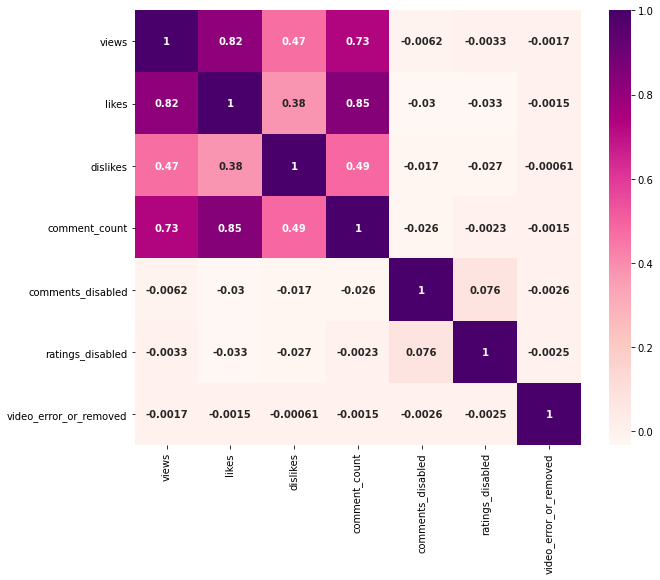

In [11]:
corr = videos["RU"].corr()
fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels = corr.columns,
            yticklabels = corr.columns,
            annot = True,
            cmap="RdPu",
            annot_kws={"weight":"bold"})

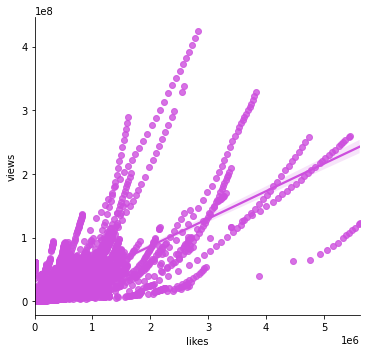

In [14]:
sns.set_palette(sns.color_palette(["#CD4FDE"]))
sns.lmplot(x="likes", y="views", data = videos["GB"])

<AxesSubplot:xlabel='trending_date', ylabel='views'>

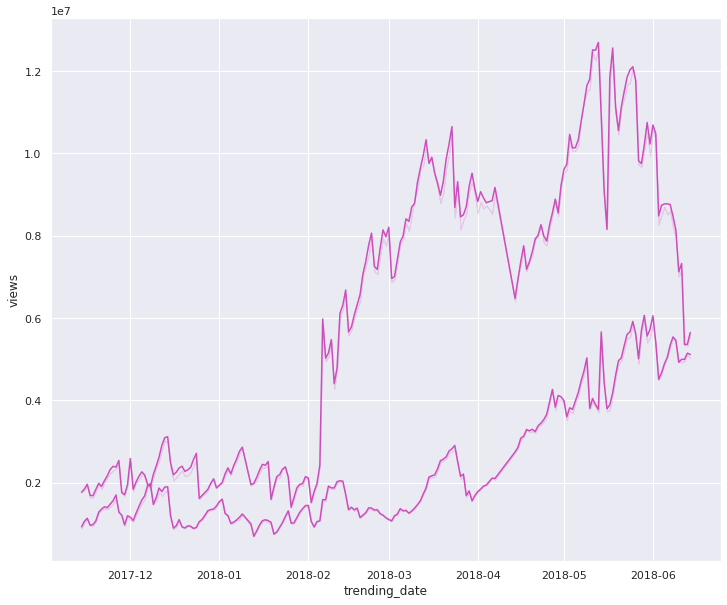

In [16]:
sns.set(rc={"figure.figsize":(12,10)})
ax = sns.lineplot(x="trending_date", y="views", data=videos["US"], ci=False, color="#CE4DBD")
sns.lineplot(x="trending_date", y="views", data=videos["GB"], ci=False, color="#CE4DBD", ax=ax)

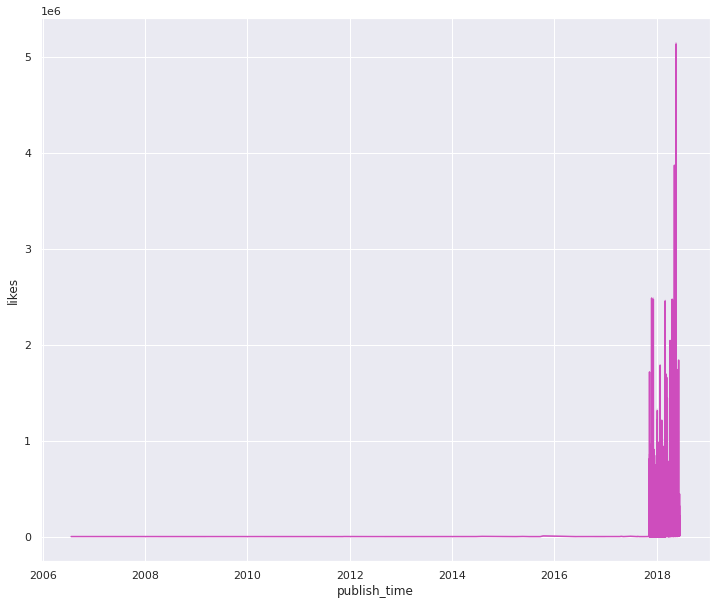

In [163]:
sns.set(rc={"figure.figsize":(12,10)})
ax = sns.lineplot(x="publish_time", y="likes", data=videos, ci=False, color="#CE4DBD")

In [126]:
videos.nunique()

title                      6455
description                6901
tags                       6055
category_id                  16
channel_title              2207
publish_time               6269
trending_date               205
views                     40478
likes                     29850
dislikes                   8516
comment_count             13773
comments_disabled             2
ratings_disabled              2
video_error_or_removed        2
thumbnail_link             6352
dtype: int64

In [9]:
videos.isna().sum()

trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64